# A RBMK geometry 
This notebook can be used as a template for modeling RBMK reactors.

SOURCES
"Fuel Assembly": https://web.archive.org/web/20090908013425/http:/www.insc.anl.gov:80/rbmk/reactor/assembly.html
"Fuel with burnable absorber for RBMK-1500", pg250-252: https://www.osti.gov/etdeweb/servlets/purl/20269236
"DESIGN AND FABRICATION OF NUCLEAR FUEL FOR WWER AND RBMK REACTORS"
Slides 8-11: indico.ictp.it/event/a04215/session/26/contribution/16/material/0/1.pdf

In [1]:
%matplotlib inline
from math import pi, sin, cos, sqrt
import numpy as np
import openmc

In [2]:
# Materials definitions

fuel = openmc.Material(name='2.0% Fuel')
fuel.add_element('U', 0.995, enrichment=2.0)
fuel.add_element('Er', 0.005)
fuel.add_nuclide('O16', 2.0)
fuel.set_density('g/cm3', 10.400)

zircaloy = openmc.Material(name='Zircaloy')
zircaloy.add_element('Zr', 0.99)
zircaloy.add_element('Nb', 0.01)
zircaloy.set_density('g/cm3', 8.59)

wall = openmc.Material(name='Carrier Rod Material')
wall.add_element('Zr', 0.975)
wall.add_element('Nb', 0.025)
wall.set_density('g/cm3', 8.59)

helium = openmc.Material(name='Helium')
helium.add_element('He', 1)
helium.set_density('g/cm3', 0.178)

# Instantiate a Materials collection and export to xml
materials_file = openmc.Materials([fuel, zircaloy, helium, wall])
materials_file.export_to_xml()

In [4]:
# Geometry definitions for the fuel rod

#Making the boundary planes for the sleeves
sleeve_min_z = openmc.ZPlane(z0=-12)
sleeve_max_z = openmc.ZPlane(z0=+12)

# Create cylinders for the fuel and clad
fuel_inner_radius = openmc.ZCylinder(r=0.55)
fuel_outer_radius = openmc.ZCylinder(r=0.566)
clad_inner_radius = openmc.ZCylinder(r=0.596)
clad_outer_radius = openmc.ZCylinder(r=0.68)

# Create a universe to encapsulate a fuel rod
pin_cell_universe = openmc.Universe(name='2.0% Fuel Pin') 

# Create fuel cell
fuel_cell_top = openmc.Cell(name='2.0% Fuel')
fuel_cell_top.fill = fuel
fuel_cell_top.region = -fuel_inner_radius & +sleeve_max_z
pin_cell_universe.add_cell(fuel_cell_top)

# Create void space
void_space_top = openmc.Cell(name='empty_space')
void_space_top.fill = helium
void_space_top.region = +fuel_inner_radius & -clad_inner_radius & +sleeve_max_z
pin_cell_universe.add_cell(void_space_top)

# Create a clad cell
clad_cell_top = openmc.Cell(name='2.0% Clad')
clad_cell_top.fill = zircaloy
clad_cell_top.region = +clad_inner_radius & -clad_outer_radius & +sleeve_max_z
pin_cell_universe.add_cell(clad_cell_top)

# Create fuel cell
fuel_cell_bot = openmc.Cell(name='2.0% Fuel')
fuel_cell_bot.fill = fuel
fuel_cell_bot.region = -fuel_inner_radius & -sleeve_min_z
pin_cell_universe.add_cell(fuel_cell_bot)

# Create void space
void_space_bot = openmc.Cell(name='empty_space')
void_space_bot.fill = helium
void_space_bot.region = +fuel_inner_radius & -clad_inner_radius & -sleeve_min_z
pin_cell_universe.add_cell(void_space_bot)

# Create a clad cell
clad_cell_bot = openmc.Cell(name='2.0% Clad')
clad_cell_bot.fill = zircaloy
clad_cell_bot.region = +clad_inner_radius & -clad_outer_radius & -sleeve_min_z
pin_cell_universe.add_cell(clad_cell_bot)

# Create an outside of pin cell
moderator = openmc.Cell(name='Moderator')
moderator.fill = helium
moderator.region = +clad_outer_radius
pin_cell_universe.add_cell(moderator)

# Create a 'sleeve' cell that slices through the middle of the elongated element
sleeve_cell = openmc.Cell(name='Sleeve')
sleeve_cell.fill = helium
sleeve_cell.region = -clad_outer_radius & +sleeve_min_z & -sleeve_max_z
pin_cell_universe.add_cell(sleeve_cell)

In [5]:
# Geometry definitions for the fuel rod

rod_inner_radius = openmc.ZCylinder(r=0.75) 
rod_outer_radius = openmc.ZCylinder(r=0.7625)

rod_cell_universe = openmc.Universe(name='Carrier Rod')

inner_rod = openmc.Cell(name='Inner Rod')
inner_rod.fill = helium
inner_rod.region = -rod_inner_radius
rod_cell_universe.add_cell(inner_rod)

outer_rod = openmc.Cell(name='Outer Rod')
outer_rod.fill = wall
outer_rod.region = +rod_inner_radius & -rod_outer_radius
rod_cell_universe.add_cell(outer_rod)

In [6]:
# Create a circular Lattice for the bundle

element_min_z = openmc.ZPlane(z0=-364, boundary_type='reflective')
element_max_z = openmc.ZPlane(z0=+364, boundary_type='reflective')
carrier_min_z = openmc.ZPlane(z0=-400, boundary_type='reflective')
carrier_max_z = openmc.ZPlane(z0=+600, boundary_type='reflective')

circlat = openmc.Universe(name='Circular Lattice')

channel = openmc.ZCylinder(r=4.5, boundary_type='reflective')

channel_cell = openmc.Cell(name='Channel')
channel_cell.fill = helium
channel_cell.region = -channel & +rod_outer_radius & +element_min_z & -element_max_z

#Calculations before finding pin placement
r_channel = 4.0
r_element = 0.68
r_outer = r_channel-r_element

padding = pi*r_outer/6-2*r_element
r_inner = r_outer*cos(pi/12)-sqrt((r_element*2+padding)**2-(r_element+padding)**2)

In [7]:
# Add the fuel pins into the channel

num_in_rings = [6, 12]
radii = [r_inner, r_outer]
angles = [0, pi/12]

for index in range(len(num_in_rings)):
  elem_num = num_in_rings[index]
  ring_radius = radii[index]
  theta_0 = angles[index]
  theta = 2*pi/elem_num
  for element in range(elem_num):
    x = ring_radius*cos(element*theta + theta_0)
    y = ring_radius*sin(element*theta + theta_0)

    pin_boundary = openmc.ZCylinder(x0=x, y0=y, r=r_element)
    pin = openmc.Cell(fill=pin_cell_universe, region=-pin_boundary & +element_min_z & -element_max_z)
    pin.translation = (x,y,0)
    pin.id = (index+1)*100 + element
    channel_cell.region &= ~pin.region
    circlat.add_cell(pin)

In [8]:
# Add the 3 Components of the Carrier Rod
rod_bound = openmc.ZCylinder(r=0.7625, boundary_type='reflective')
rod_channel_min = openmc.ZPlane(z0=-364)
rod_channel_max = openmc.ZPlane(z0=+364)

rod_above = openmc.Cell(fill=rod_cell_universe, region=-rod_bound & -carrier_max_z & +rod_channel_max)
rod_mid = openmc.Cell(fill=rod_cell_universe, region=-rod_outer_radius & +rod_channel_min & -rod_channel_max)
rod_below = openmc.Cell(fill=rod_cell_universe, region=-rod_bound & -rod_channel_min & +carrier_min_z)

circlat.add_cell(rod_above)
circlat.add_cell(rod_mid)
circlat.add_cell(rod_below)
circlat.add_cell(channel_cell)

In [9]:
geometry = openmc.Geometry(circlat)
geometry.export_to_xml()

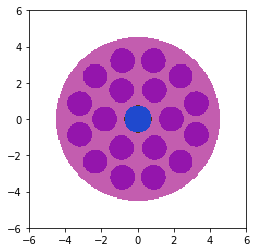

In [14]:
circlat.plot(width=(12, 12), basis='xy')

In [15]:
# OpenMC simulation parameters

batches = 100
inactive = 10
particles = 5000

settings_file = openmc.Settings()
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles

bounds = [-3, -3, -2.4, 3, 3, 2.4]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=False) #only_fissionable != True due to lots of helium
settings_file.source = openmc.Source(space=uniform_dist)

settings_file.export_to_xml()

In [16]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      100/1    0.41280    0.42054 +/- 0.00068
 Creating state point statepoint.100.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 3.5405e+00 seconds
   Reading cross sections          = 3.4979e+00 seconds
 Total time in simulation          = 7.6338e+01 seconds
   Time in transport only          = 7.6297e+01 seconds
   Time in inactive batches        = 7.5955e+00 seconds
   Time in active batches          = 6.8742e+01 seconds
   Time synchronizing fission bank = 1.7017e-02 seconds
     Sampling source sites         = 1.3410e-02 seconds
     SEND/RECV source sites        = 3.5210e-03 seconds
   Time accumulating tallies       = 3.9000e-05 seconds
   Time writing statepoints        = 5.7760e-03 seconds
 Total time for finalization       = 4.0000e-06 seconds
 Total time elapsed                = 7.9891e+01 seconds
 Calculation Rate (inactive)       = 6582.89 particles/second
 Calculation Rate (active)         = 6546.